# **Importando bibliotecas e o dataset**

In [ ]:
import pandas               as pd
from   google.colab         import drive
import matplotlib.pyplot    as plt
import seaborn              as sns
import plotly.express       as px
import plotly.graph_objects as go
import re
import uuid
import nltk
import string
from   nltk.corpus          import stopwords
from   nltk.tokenize        import word_tokenize, RegexpTokenizer
import unidecode
from   nltk.sentiment       import SentimentIntensityAnalyzer
from   wordcloud            import WordCloud
from   collections          import Counter


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
caminho_do_arquivo = ('/content/drive/My Drive/OPER/reviews.csv')

df = pd.read_csv(caminho_do_arquivo)

In [ ]:
df.columns

Index(['Reviewer Name', 'Profile Link', 'Country', 'Review Count',
       'Review Date', 'Rating', 'Review Title', 'Review Text',
       'Date of Experience'],
      dtype='object')

# **Análise Exploratória**

In [ ]:
df.shape


(131980, 9)

In [ ]:
df.describe()

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
count,131917,131980,131976,131980,131980,131980,131932,131980,131980
unique,111453,131914,181,56,131616,5,90452,91107,2595
top,customer,/users/64b81c2e4b86b400126ce1a8,US,1 review,2023-07-19T19:23:59.000Z,Rated 5 out of 5 stars,Great,Review text not found,"November 25, 2022"
freq,994,2,121912,92203,3,90874,2240,37867,1157


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131980 entries, 0 to 131979
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Reviewer Name       131917 non-null  object
 1   Profile Link        131980 non-null  object
 2   Country             131976 non-null  object
 3   Review Count        131980 non-null  object
 4   Review Date         131980 non-null  object
 5   Rating              131980 non-null  object
 6   Review Title        131932 non-null  object
 7   Review Text         131980 non-null  object
 8   Date of Experience  131980 non-null  object
dtypes: object(9)
memory usage: 9.1+ MB


In [ ]:
print(df.isnull().sum())

Reviewer Name         63
Profile Link           0
Country                4
Review Count           0
Review Date            0
Rating                 0
Review Title          48
Review Text            0
Date of Experience     0
dtype: int64


In [ ]:
duplicates = df.duplicated().sum()
print(f'Número de linhas duplicadas: {duplicates}')

Número de linhas duplicadas: 66


**Todas colunas são do tipo object, e temos uma quantidade de valores nulos e duplicados, nesse caso iremos utilizar a abordagem mais simples de dropar as colunas para ter um dataset mais limpo, já que essa ação não irá interferir tão bruscamente em nossa análise.**

In [ ]:
df.dropna(inplace=True, axis=0)
df.drop_duplicates(inplace=True)


In [ ]:
df.shape

(131802, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131802 entries, 0 to 131979
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Reviewer Name       131802 non-null  object
 1   Profile Link        131802 non-null  object
 2   Country             131802 non-null  object
 3   Review Count        131802 non-null  object
 4   Review Date         131802 non-null  object
 5   Rating              131802 non-null  object
 6   Review Title        131802 non-null  object
 7   Review Text         131802 non-null  object
 8   Date of Experience  131802 non-null  object
dtypes: object(9)
memory usage: 10.1+ MB


In [ ]:
df.columns= df.columns.str.lower()


In [ ]:
df.columns=df.columns.str.replace(' ','_')


In [ ]:
df.columns

Index(['reviewer_name', 'profile_link', 'country', 'review_count',
       'review_date', 'rating', 'review_title', 'review_text',
       'date_of_experience'],
      dtype='object')

**Agora iremos olhar mais atentamente para as colunas de review_count, review_date, e rating para realizar algumas modificações antes de começar a análise**

In [ ]:
## Aqui faremos a conversão das colunas para tipo inteiro, bem como eliminar os textos que não farão parte das análises
df['review_count'] = df['review_count'].astype(str).str[0].astype(int)
df['rating']=df['rating'].str.extract('(\d)').astype(int)

In [ ]:
## Vamos converter as colunas de data das colunas que possuem esse formato para trabalharmos com elas

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['date_of_experience'] = pd.to_datetime(df['date_of_experience'], format='%B %d, %Y', errors='coerce')


# **Satisfação do Cliente**


**Quantidade de Avaliações Por Ano**

In [ ]:
df['year'] = df['review_date'].dt.year
count = df['year'].value_counts().sort_index(ascending=True)
fig = go.Figure(data=[go.Bar(x=count.index, y=count.values, text=count.values, textposition='outside')])
fig.update_layout(
    title='Avaliações por Ano',
    xaxis_title='Ano',
    yaxis_title='Número de Avaliações',
    template='plotly_white',
    width=800,
    height=600
)
fig.show()

**Quantidade de Notas de Avaliação**

In [ ]:
count = df['rating'].value_counts()
fig = go.Figure(data=[go.Bar(x=count.index, y=count.values, text=count.values, textposition='outside')])

fig.update_layout(
    title='Contagem de Notas de Avaliação',
    xaxis_title='Nota de Avaliação',
    yaxis_title='Número de Avaliações',
    template='plotly_white',
    width=800,
    height=600
)

In [ ]:
rating_by_year = df.groupby('year').agg(
    average_rating=('rating', 'mean'),
    review_count=('rating', 'size')
).reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=rating_by_year['year'],
                         y=rating_by_year['average_rating'],
                         mode='lines+markers',
                         name='Média das Avaliações',
                         line=dict(color='blue')))
fig.add_trace(go.Bar(x=rating_by_year['year'],
                     y=rating_by_year['review_count'],
                     name='Quantidade de Avaliações',
                     yaxis='y2',
                     marker=dict(color='orange')))
fig.update_layout(
    title='Evolução das Notas de Avaliação e Quantidade de Avaliações por Ano',
    xaxis_title='Ano',
    yaxis_title='Média das Avaliações',
    yaxis2=dict(
        title='Quantidade de Avaliações',
        overlaying='y',
        side='right'
    ),barmode='group',
    template='plotly_white',
)

fig.show()

# **Segmentação de Mercado**

**Farei uma mudança na coluna country para exibir os nomes dos países por extenso e facilitar a compreensão**

In [ ]:
unique_countries = df['country'].unique()

print(unique_countries)

['US' 'VG' 'CA' 'PT' 'MY' 'BM' 'IQ' 'TT' 'DE' 'GB' 'JM' 'NG' 'PL' 'IN'
 'MX' 'BS' 'AU' 'PA' 'KN' 'KE' 'BB' 'BR' 'FR' 'AF' 'PS' 'BZ' 'LS' 'AE'
 'SC' 'VI' 'LC' 'GR' 'XK' 'BE' 'NL' 'GP' 'AI' 'ZA' 'NZ' 'KW' 'HR' 'SR'
 'DK' 'IE' 'CV' 'SG' 'AG' 'ZM' 'CM' 'GD' 'ES' 'CW' 'CO' 'LT' 'TR' 'DZ'
 'MC' 'DO' 'GY' 'RU' 'CL' 'SE' 'PR' 'TN' 'LB' 'BO' 'DM' 'HK' 'MQ' 'RW'
 'HT' 'PE' 'FI' 'KY' 'GE' 'LV' 'SN' 'PK' 'TC' 'MZ' 'TH' 'AT' 'KR' 'IL'
 'BW' 'SA' 'GU' 'GH' 'CH' 'DJ' 'AW' 'JP' 'NO' 'IS' 'CI' 'IT' 'GT' 'VC'
 'VE' 'EC' 'SV' 'MV' 'AO' 'MU' 'SL' 'CR' 'EG' 'AR' 'HN' 'AL' 'SS' 'SX'
 'BA' 'TZ' 'BQ' 'MA' 'NP' 'RE' 'MW' 'NI' 'RO' 'PF' 'ZW' 'TW' 'PH' 'CY'
 'GL' 'VN' 'HU' 'QA' 'UG' 'UY' 'BH' 'RS' 'ET' 'MK' 'VU' 'MP' 'SZ' 'AM'
 'MF' 'AZ' 'SK' 'CZ' 'MT' 'KH' 'SI' 'BD' 'LU' 'GF' 'ID' 'FO' 'NC' 'OM'
 'UZ' 'BG' 'UA' 'CD' 'CU' 'PG' 'CG' 'KZ' 'EE' 'ME' 'LK' 'CN' 'AS' 'LR'
 'GM' 'BL' 'JO' 'PW' 'FK' 'SO' 'MO' 'KG' 'PY' 'TG' 'MD' 'GI' 'BY']


In [ ]:
country_dict = {
    'US': 'United States', 'VG': 'British Virgin Islands', 'CA': 'Canada', 'PT': 'Portugal',
    'MY': 'Malaysia', 'BM': 'Bermuda', 'IQ': 'Iraq', 'TT': 'Trinidad and Tobago', 'DE': 'Germany',
    'GB': 'United Kingdom', 'JM': 'Jamaica', 'NG': 'Nigeria', 'PL': 'Poland', 'IN': 'India',
    'MX': 'Mexico', 'BS': 'Bahamas', 'AU': 'Australia', 'PA': 'Panama', 'KN': 'Saint Kitts and Nevis',
    'KE': 'Kenya', 'BB': 'Barbados', 'BR': 'Brazil', 'FR': 'France', 'AF': 'Afghanistan', 'PS': 'Palestine',
    'BZ': 'Belize', 'LS': 'Lesotho', 'AE': 'United Arab Emirates', 'SC': 'Seychelles', 'VI': 'U.S. Virgin Islands',
    'LC': 'Saint Lucia', 'GR': 'Greece', 'XK': 'Kosovo', 'BE': 'Belgium', 'NL': 'Netherlands',
    'GP': 'Guadeloupe', 'AI': 'Anguilla', 'ZA': 'South Africa', 'NZ': 'New Zealand', 'KW': 'Kuwait',
    'HR': 'Croatia', 'SR': 'Suriname', 'DK': 'Denmark', 'IE': 'Ireland', 'CV': 'Cape Verde',
    'SG': 'Singapore', 'AG': 'Antigua and Barbuda', 'ZM': 'Zambia', 'CM': 'Cameroon', 'GD': 'Grenada',
    'ES': 'Spain', 'CW': 'Curaçao', 'CO': 'Colombia', 'LT': 'Lithuania', 'TR': 'Turkey', 'DZ': 'Algeria',
    'MC': 'Monaco', 'DO': 'Dominican Republic', 'GY': 'Guyana', 'RU': 'Russia', 'CL': 'Chile',
    'SE': 'Sweden', 'PR': 'Puerto Rico', 'TN': 'Tunisia', 'LB': 'Lebanon', 'BO': 'Bolivia',
    'DM': 'Dominica', 'HK': 'Hong Kong', 'MQ': 'Martinique', 'RW': 'Rwanda', 'HT': 'Haiti',
    'PE': 'Peru', 'FI': 'Finland', 'KY': 'Cayman Islands', 'GE': 'Georgia', 'LV': 'Latvia',
    'SN': 'Senegal', 'PK': 'Pakistan', 'TC': 'Turks and Caicos Islands', 'MZ': 'Mozambique',
    'TH': 'Thailand', 'AT': 'Austria', 'KR': 'South Korea', 'IL': 'Israel', 'BW': 'Botswana',
    'SA': 'Saudi Arabia', 'GU': 'Guam', 'GH': 'Ghana', 'CH': 'Switzerland', 'DJ': 'Djibouti',
    'AW': 'Aruba', 'JP': 'Japan', 'NO': 'Norway', 'IS': 'Iceland', 'CI': 'Ivory Coast', 'IT': 'Italy',
    'GT': 'Guatemala', 'VC': 'Saint Vincent and the Grenadines', 'VE': 'Venezuela', 'EC': 'Ecuador',
    'SV': 'El Salvador', 'MV': 'Maldives', 'AO': 'Angola', 'MU': 'Mauritius', 'SL': 'Sierra Leone',
    'CR': 'Costa Rica', 'EG': 'Egypt', 'AR': 'Argentina', 'HN': 'Honduras', 'AL': 'Albania',
    'SS': 'South Sudan', 'SX': 'Sint Maarten', 'BA': 'Bosnia and Herzegovina', 'TZ': 'Tanzania',
    'BQ': 'Bonaire', 'MA': 'Morocco', 'NP': 'Nepal', 'RE': 'Réunion', 'MW': 'Malawi', 'NI': 'Nicaragua',
    'RO': 'Romania', 'PF': 'French Polynesia', 'ZW': 'Zimbabwe', 'TW': 'Taiwan', 'PH': 'Philippines',
    'CY': 'Cyprus', 'GL': 'Greenland', 'VN': 'Vietnam', 'HU': 'Hungary', 'QA': 'Qatar', 'UG': 'Uganda',
    'UY': 'Uruguay', 'BH': 'Bahrain', 'RS': 'Serbia', 'ET': 'Ethiopia', 'MK': 'North Macedonia',
    'VU': 'Vanuatu', 'MP': 'Northern Mariana Islands', 'SZ': 'Eswatini', 'AM': 'Armenia', 'MF': 'Saint Martin',
    'AZ': 'Azerbaijan', 'SK': 'Slovakia', 'CZ': 'Czech Republic', 'MT': 'Malta', 'KH': 'Cambodia',
    'SI': 'Slovenia', 'BD': 'Bangladesh', 'LU': 'Luxembourg', 'GF': 'French Guiana', 'ID': 'Indonesia',
    'FO': 'Faroe Islands', 'NC': 'New Caledonia', 'OM': 'Oman', 'UZ': 'Uzbekistan', 'BG': 'Bulgaria',
    'UA': 'Ukraine', 'CD': 'Democratic Republic of the Congo', 'CU': 'Cuba', 'PG': 'Papua New Guinea',
    'CG': 'Republic of the Congo', 'KZ': 'Kazakhstan', 'EE': 'Estonia', 'ME': 'Montenegro',
    'LK': 'Sri Lanka', 'CN': 'China', 'AS': 'American Samoa', 'LR': 'Liberia', 'GM': 'Gambia',
    'BL': 'Saint Barthelemy', 'JO': 'Jordan', 'PW': 'Palau', 'FK': 'Falkland Islands', 'SO': 'Somalia',
    'MO': 'Macau', 'KG': 'Kyrgyzstan', 'PY': 'Paraguay', 'TG': 'Togo', 'MD': 'Moldova', 'GI': 'Gibraltar',
    'BY': 'Belarus'
}

def convert_country_code(code):
    return country_dict.get(code, 'Unknown')

df['country_name'] = df['country'].apply(convert_country_code)

print(df[['country', 'country_name']].head())


  country            country_name
0      US           United States
1      VG  British Virgin Islands
2      US           United States
3      US           United States
4      US           United States


In [ ]:
## Movendo a coluna 'country_name' para ficar em ordem

cols = df.columns.tolist()

cols.remove('country_name')
cols.insert(3, 'country_name')

df = df[cols]


In [ ]:
## Contagem dos 10 países com mais reviews usando a coluna 'country_name'
top_countries = df['country_name'].value_counts().head(10)

fig = go.Figure(data=[go.Bar(
    x=top_countries.index,
    y=top_countries.values,
    text=top_countries.values,
    textposition='outside',
    marker=dict(color=top_countries.values, colorscale='cividis')
)])

fig.update_layout(
    title='Top 10 Países com Maior Contagem de Reviews',
    xaxis_title='Países',
    yaxis_title='Contagem de Reviews',
    template='plotly_white',
    xaxis_tickangle=45
)

fig.show()


In [ ]:

top_countries_percentage = (df['country_name'].value_counts(normalize=True) *100).head(10)

print("Top 10 countries by percentage of total reviews:\n", top_countries_percentage)

Top 10 countries by percentage of total reviews:
 country_name
United States          92.366580
Canada                  2.499203
United Kingdom          0.949910
Australia               0.411982
Jamaica                 0.382392
Trinidad and Tobago     0.258721
Bahamas                 0.175263
Mexico                  0.138086
Germany                 0.135051
India                   0.125946
Name: proportion, dtype: float64


In [ ]:
## Contagem dos 10 países com menos reviews usando a coluna 'country_name'
top_countries = df['country_name'].value_counts().tail(10)

fig = go.Figure(data=[go.Bar(
    x=top_countries.index,
    y=top_countries.values,
    text=top_countries.values,
    textposition='outside',
    marker=dict(color=top_countries.values, colorscale='cividis')
)])

fig.update_layout(
    title='Top 10 Países com Menor Contagem de Reviews',
    xaxis_title='Países',
    yaxis_title='Contagem de Reviews',
    template='plotly_white',
    xaxis_tickangle=45
)

fig.show()

In [ ]:

top_countries_percentage = (df['country_name'].value_counts(normalize=True) *100).tail(10)

print("Top 10 countries by percentage of total reviews:\n", top_countries_percentage)

Top 10 countries by percentage of total reviews:
 country_name
Papua New Guinea    0.000759
Cuba                0.000759
Uzbekistan          0.000759
Bangladesh          0.000759
Eswatini            0.000759
Vanuatu             0.000759
Tanzania            0.000759
South Sudan         0.000759
Lesotho             0.000759
Belarus             0.000759
Name: proportion, dtype: float64


In [ ]:
## Vamos analisar quais são os TOP 10 Países que possuem as maiores notas de avaliação

top_countries_rating = df.groupby('country_name')['rating'].mean().sort_values(ascending=False).reset_index()

top_10_countries_rating = top_countries_rating.head(10)
print(top_10_countries_rating)


       country_name  rating
0        Kyrgyzstan     5.0
1              Oman     5.0
2          Ethiopia     5.0
3  Falkland Islands     5.0
4            Gambia     5.0
5              Iraq     5.0
6             Macau     5.0
7            Monaco     5.0
8        Montenegro     5.0
9             Nepal     5.0


In [ ]:
## Analisando os países que possuem maior nota média de avaliação

media_classificacao_pais = df.groupby('country_name')['rating'].mean().sort_values(ascending=False).head(10).reset_index()
fig = px.bar(media_classificacao_pais, x='country_name', y='rating',
             title='Média de Classificação por País',
             labels={'country_name': 'Países', 'rating': 'Média de Classificação'},
             color='rating', color_continuous_scale='Viridis')
fig.update_xaxes(tickangle=45)
fig.show()

In [ ]:
## Vamos analisar quais são os TOP 10 Países que possuem as menores notas de avaliação

top_countries_rating = df.groupby('country_name')['rating'].mean().sort_values(ascending=False).reset_index()

top_10_countries_rating = top_countries_rating.tail(10)
print(top_10_countries_rating)

              country_name  rating
171                Liberia     2.0
172                 Jordan     2.0
173  Republic of the Congo     2.0
174                   Togo     1.0
175               Eswatini     1.0
176                Bolivia     1.0
177             Uzbekistan     1.0
178                Belarus     1.0
179              Gibraltar     1.0
180             Kazakhstan     1.0


In [ ]:
## Top 5 países com média de avaliação acima de 4.0

linha = df['rating'] >= 4.0
df_aux = (df.loc[linha, ['country_name']]
          .groupby('country_name')
          .size()
          .sort_values(ascending=False)
          .reset_index(name='review_count')
          .head(5))

fig = px.bar(df_aux, x='country_name', y='review_count',
             title='Top 5 Países com Avaliações (Rating >= 4.0)',
             labels={'country_name': 'Países', 'review_count': 'Contagem de Avaliações'},
             color='review_count', color_continuous_scale='Viridis')

fig.update_xaxes(tickangle=45)
fig.show()

In [ ]:
## Top 5 países com média de avaliação abaixo de 2.5
linha = df['rating'] >= 4.0
df_aux = (df.loc[linha, ['country_name']]
          .groupby('country_name')
          .size()
          .sort_values(ascending=False)
          .reset_index(name='review_count')
          .tail(5))

fig = px.bar(df_aux, x='country_name', y='review_count',
             title='Top 5 Países com Avaliações (Rating <= 2.5)',
             labels={'country_name': 'Países', 'review_count': 'Contagem de Avaliações'},
             color='review_count', color_continuous_scale='Viridis')

fig.update_xaxes(tickangle=45)
fig.show()

# **Engajamento do Cliente**


In [ ]:
## Verificando os nomes únicos e contando quantas vezes aparecem
unique_names = df['reviewer_name'].value_counts()

print("Nomes únicos em 'reviewer_name':")
print(unique_names)

Nomes únicos em 'reviewer_name':
reviewer_name
customer           991
Anonymous          158
Customer           146
Dee                126
Ashley             110
                  ... 
Cerias Pierre        1
SunShine             1
Tash Jewell          1
Alicia Guerra        1
Ashlee Ann Tyra      1
Name: count, Length: 111420, dtype: int64


In [ ]:
## Para realizarmos análises mais efetivas dos avaliadores vamos criar uma
## coluna com IDs únicos para que possamos realizar com maior assertividade as próximas análises


unique_links = df['profile_link'].unique()
ids_unicos = {link: str(uuid.uuid4()) for link in unique_links}
df['profile_id'] = df['profile_link'].map(ids_unicos)
print(df[['profile_link', 'profile_id']].head())

                      profile_link                            profile_id
0  /users/66c78240087b6269ffbcb5fb  70b8f548-feac-41d5-8947-22319e5dea87
1  /users/6618fdb53d4198001210cbe7  79d924ac-aa46-4aaa-b166-d7cd922d7ea9
2  /users/64e9595206be1a001244ff73  20ec4aec-7008-48ee-ab90-6bc16f9e91ac
3  /users/66c58ad1c6ab36352a08f57a  6c099b91-6423-4ee1-9c4c-e0748649c2f7
4  /users/60ad4b6ef3788e001adbb8e3  5c890e7c-ca36-4b6f-bdfc-95b70b960bf6


In [ ]:
## Movendo a coluna 'profile_id' para ficar em ordem

cols = df.columns.tolist()

cols.remove('profile_id')
cols.insert(2, 'profile_id')

df = df[cols]

In [ ]:
## Analisando os avaliadores mais frequentes e separando por País

avaliadores_frequentes = df.groupby('profile_id')['review_count'].sum().sort_values(ascending=False)
top_avaliadores = avaliadores_frequentes.head(10).reset_index(name='review_count')
top_avaliadores = top_avaliadores.merge(df[['profile_id', 'country_name']].drop_duplicates(),
                                        on='profile_id', how='left')

fig = px.bar(top_avaliadores, x='profile_id', y='review_count', color='country_name',
             title='Top 10 Avaliadores Mais Frequentes por País',
             labels={'profile_id': 'Avaliador', 'review_count': 'Contagem de Avaliações', 'country_name': 'País'},
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_xaxes(tickangle=45)
fig.show()


In [ ]:
avaliadores_frequentes = df.groupby('profile_id')['review_count'].sum().sort_values(ascending=True)
top_avaliadores = avaliadores_frequentes.head(10).reset_index(name='review_count')
top_avaliadores = top_avaliadores.merge(df[['profile_id', 'country_name']].drop_duplicates(),
                                        on='profile_id', how='left')

fig = px.bar(top_avaliadores, x='profile_id', y='review_count', color='country_name',
             title='Top 10 Avaliadores Menos Frequentes por País',
             labels={'profile_id': 'Avaliador', 'review_count': 'Contagem de Avaliações', 'country_name': 'País'},
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_xaxes(tickangle=45)
fig.show()


In [ ]:
## Avaliadores que possuem as notas maiores, e podem ser considerados clientes fiéis a marca

clientes_fieis = df[df['rating'] > 4.0]
avaliadores_fieis = clientes_fieis.groupby('profile_id')['review_count'].sum().sort_values(ascending=False)
top_clientes_fieis = avaliadores_fieis.head(10).reset_index(name='review_count')
top_clientes_fieis = top_clientes_fieis.merge(df[['profile_id', 'country_name']].drop_duplicates(),
                                              on='profile_id', how='left')

fig = px.bar(top_clientes_fieis, x='profile_id', y='review_count', color='country_name',
             title='Top 10 Clientes Fieis com Avaliações Maiores que 4',
             labels={'profile_id': 'Avaliador', 'review_count': 'Contagem de Avaliações', 'country_name': 'País'},
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_xaxes(tickangle=45)
fig.show()



In [ ]:
## Identificando os 10 clientes que deixaram 1 ou 2 avaliações
clientes_menos_engajados = df.groupby('profile_id')['review_count'].max().head(10)
clientes_menos_engajados = clientes_menos_engajados[clientes_menos_engajados <= 2]

clientes_menos_engajados


,review_count
profile_id,
000037f4-4440-460e-881a-9066765e6b84,1
0000d423-d2c2-426a-92c4-2488743bc377,1
0000e14d-daba-45e4-a0ce-8ecfc8ac149b,1
00023695-a886-4d66-b0cf-3cd4881bb865,1
0002b488-2beb-42f6-901d-81cf7897dbf5,1
0002f985-19f6-487c-b901-ba523874b044,1


<Figure size 1200x800 with 0 Axes>

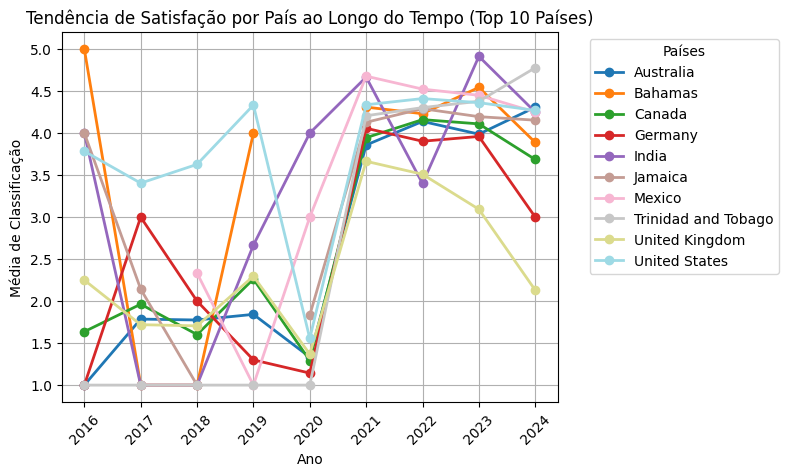

In [ ]:
## Calculando a média de classificação por país e ano
top_10_paises = df['country_name'].value_counts().head(10).index
df_top_10_paises = df[df['country_name'].isin(top_10_paises)]
tendencia_satisfacao_pais_ano = df_top_10_paises.groupby(['year', 'country_name'])['rating'].mean().unstack()
plt.figure(figsize=(12, 8))
tendencia_satisfacao_pais_ano.plot(kind='line', marker='o', cmap='tab20', linewidth=2)
plt.title('Tendência de Satisfação por País ao Longo do Tempo (Top 10 Países)')
plt.xlabel('Ano')
plt.ylabel('Média de Classificação')
plt.xticks(rotation=45)
plt.legend(title='Países', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


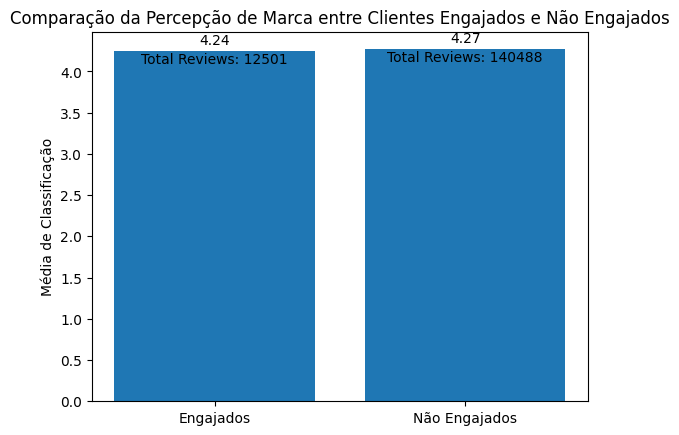

In [ ]:
# Definindo um critério para clientes engajados (exemplo: mais de 5 avaliações)
clientes_engajados = df[df['review_count'] > 5]
clientes_nao_engajados = df[df['review_count'] <= 2]

media_engajados = clientes_engajados['rating'].mean()
media_nao_engajados = clientes_nao_engajados['rating'].mean()

total_engajados = clientes_engajados['review_count'].sum()
total_nao_engajados = clientes_nao_engajados['review_count'].sum()

labels = ['Engajados', 'Não Engajados']
ratings = [media_engajados, media_nao_engajados]

plt.bar(labels, ratings)

for i, rating in enumerate(ratings):
    plt.text(i, rating + 0.05, round(rating, 2), ha='center', va='bottom')

plt.text(0, media_engajados - 0.1, f'Total Reviews: {total_engajados}', ha='center', va='center')
plt.text(1, media_nao_engajados - 0.1, f'Total Reviews: {total_nao_engajados}', ha='center', va='center')

plt.title('Comparação da Percepção de Marca entre Clientes Engajados e Não Engajados')
plt.ylabel('Média de Classificação')
plt.show()


# **Análise Temporal**

In [ ]:
## Nesse gráfico iremos analisar a contagem de avaliações por período

df['month_year'] = df['review_date'].dt.to_period('M').astype(str)
df_count = df.groupby('month_year').size().reset_index(name='review_count')

fig = px.line(df_count, x='month_year', y='review_count',
              title='Quantidade de Avaliações ao Longo do Tempo',
              labels={'month_year': 'Mês/Ano', 'review_count': 'Contagem de Avaliações'}, markers=True)

fig.update_xaxes(tickangle=45)
fig.show()


In [ ]:
## Aqui realizamos uma análise para verificar como ocorreu a média das avaliações por ano

df['month'] = df['review_date'].dt.month
df['year'] = df['review_date'].dt.year

seasonal_ratings = df.groupby(['year', 'month'])['rating'].mean().reset_index(name='average_rating')

fig = px.line(seasonal_ratings, x='month', y='average_rating', color='year',
              title='Média de Avaliação por Mês ao Longo dos Anos',
              labels={'month': 'Mês', 'average_rating': 'Média de Classificação'},
              markers=True)
fig.show()


In [ ]:
## Nessa análise iremos verificar se o tempo de resposta entre a compra e a avaliação influenciam na experiência do cliente

df['review_date'] = pd.to_datetime(df['review_date']).dt.tz_localize(None)
df['date_of_experience'] = pd.to_datetime(df['date_of_experience']).dt.tz_localize(None)

df['response_time'] = (df['review_date'] - df['date_of_experience']).dt.days
fig = px.scatter(df, x='response_time', y='rating',
                 title='Relação entre Tempo de Resposta e Classificação',
                 labels={'response_time': 'Tempo de Resposta (dias)', 'rating': 'Classificação'})

fig.update_xaxes(dtick=100)
fig.show()



In [ ]:
media_satisfacao_comparacao = df.groupby(['year'])['rating'].mean().reset_index().round(2)

fig = px.bar(media_satisfacao_comparacao,
             x='year',
             y='rating',
             title='Comparação de Satisfação entre Anos',
             labels={'year': 'Ano', 'rating': 'Média de Classificação'},
             color='year',
             color_continuous_scale='Viridis',
             text='rating')

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

fig.show()

In [ ]:
top_5_dates = df['date_of_experience'].value_counts().head(10)
print(top_5_dates)


date_of_experience
2022-11-25    1157
2021-11-24    1118
2022-11-28    1090
2021-07-21     957
2021-07-22     919
2021-11-08     861
2021-11-03     856
2021-11-09     847
2021-11-04     819
2021-10-15     808
Name: count, dtype: int64


# **Análise de Sentimento das Avaliações**



In [ ]:
!pip install nltk
!pip install unidecode

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

**Pré Processamento de Texto**

In [ ]:
def converter_minusculo(text):
  return text.lower()

In [ ]:
def remove_branco (text):
  return text.strip()

In [ ]:
def remove_pontuacao(text):
    pont_str = string.punctuation
    pont_str = pont_str.replace("'", "")
    return text.translate(str.maketrans("", "", pont_str))

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        u"[\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\u2702-\u27B0"
        u"\u24C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [ ]:
def remove_http(text):
    http = r'https?://\S+|www\.\S+'
    pattern = r'({})'.format(http)
    return re.sub(pattern, "", text)

In [ ]:
regexp = RegexpTokenizer(r'\w+')
stops = set(stopwords.words('english'))
def remove_stopword(text):
    return " ".join([word for word in regexp.tokenize(text) if word.lower() not in stops])

In [ ]:
chat_words={
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BF": "Boy Friend",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "lol": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "4MY": "For My",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "R": "Are",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when. TFW internet slang often goes in a caption to an image.",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing"

}

In [ ]:
def chat_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [ ]:
def text_normalizer(text):
  text = unidecode.unidecode(text)
  text = re.sub('\n', '', text)
  text = converter_minusculo(text)
  text = remove_branco(text)
  text = remove_emoji(text)
  text = remove_http (text)
  text = remove_pontuacao(text)
  text = remove_stopword(text)
  text = chat_conversion(text)
  return text

In [ ]:
df['review_text'] = df['review_text'].astype(str)
df['review_title'] = df['review_title'].astype(str)


In [ ]:
df['clean_review_text'] = df['review_text'].apply(text_normalizer)
df['clean_review_title'] = df['review_title'].apply(text_normalizer)

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
def vader_sentiment(text):
    vs = sia.polarity_scores(text)
    if vs['compound'] > 0.25:
        return 'positive'
    elif vs['compound'] < -0.25:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
df['vader_sentiment'] = df['clean_review_text'].apply(vader_sentiment)

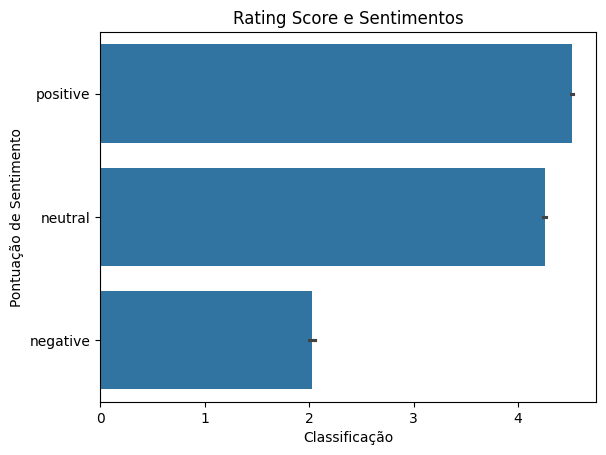

In [ ]:
ax = sns.barplot(data=df, x='rating', y='vader_sentiment')
ax.set_title('Rating Score e Sentimentos')
ax.set_xlabel('Classificação')
ax.set_ylabel('Pontuação de Sentimento')
plt.show()

In [ ]:
def get_compound(text):
    return sia.polarity_scores(text)['compound']

In [ ]:
df['sia_compound'] = df['clean_review_text'].apply(get_compound)


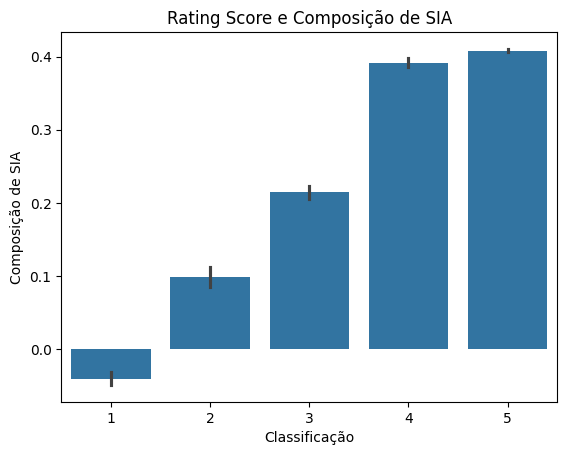

In [ ]:
ax = sns.barplot(data=df, x='rating', y='sia_compound')
ax.set_title('Rating Score e Composição de SIA')
ax.set_xlabel('Classificação')
ax.set_ylabel('Composição de SIA')
plt.show()

In [ ]:
sentiment_counts = df['vader_sentiment'].value_counts()

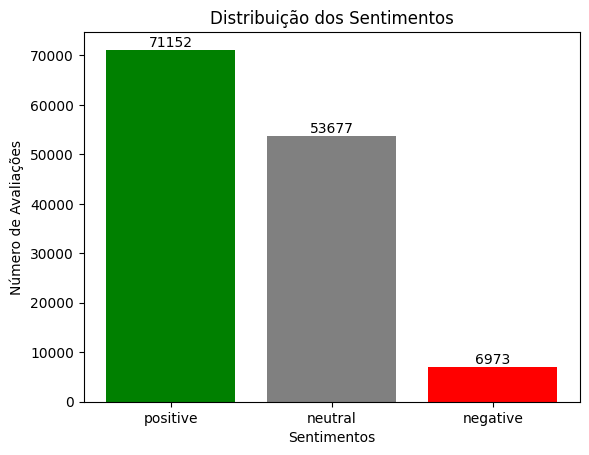

In [ ]:
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'])
plt.xlabel('Sentimentos')
plt.ylabel('Número de Avaliações')
plt.title('Distribuição dos Sentimentos')
for i, value in enumerate(sentiment_counts.values):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
plt.show()

**PALAVRAS QUE MAIS APARECEM COMO POSITIVAS NAS AVALIAÇÕES**

In [ ]:
positive_data = []
for text in df[df['vader_sentiment'] == 'positive']['clean_review_text'].tolist():
    for t in text.split():
        positive_data.append(t)

In [ ]:
positive_data_df = pd.DataFrame(positive_data, columns=['Word'])

word_counts = positive_data_df['Word'].value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']
print(word_counts.head(10))

      Word  Frequency
0     love      25409
1    great      18803
2  fashion      15913
3     nova      14544
4  clothes      12635
5     easy      10828
6     good      10307
7   always       9197
8    order       8178
9  quality       8091


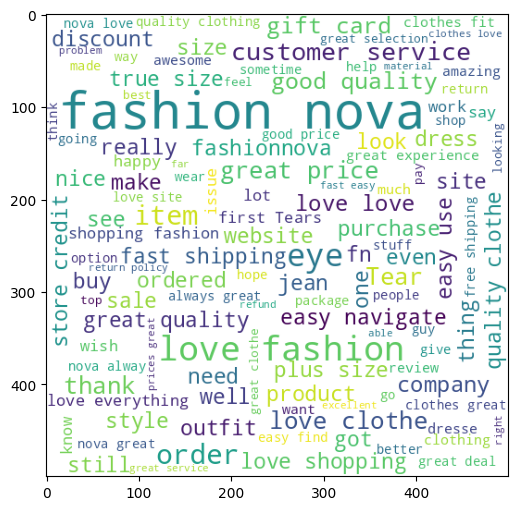

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
positive_wc = wc.generate(df[df['vader_sentiment'] == 'positive']['clean_review_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(positive_wc)

**PALAVRAS QUE MAIS APARECEM COMO NEGATIVAS NAS AVALIAÇÕES**

In [ ]:
negative_data = []
for text in df[df['vader_sentiment'] == 'negative']['clean_review_text'].tolist():
    for t in text.split():
        negative_data.append(t)

In [ ]:
## Exibindo as 10 palavras negativas mais frequentes nos títulos das avaliações

negative_data_df = pd.DataFrame(negative_data, columns=['Word'])

word_counts = negative_data_df['Word'].value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']
print(word_counts.head(10))

       Word  Frequency
0     order       3952
1     never       2151
2  customer       2105
3   service       2084
4   fashion       2062
5      eyes       2061
6        my       2054
7        in       2054
8     Tears       2054
9      nova       1999


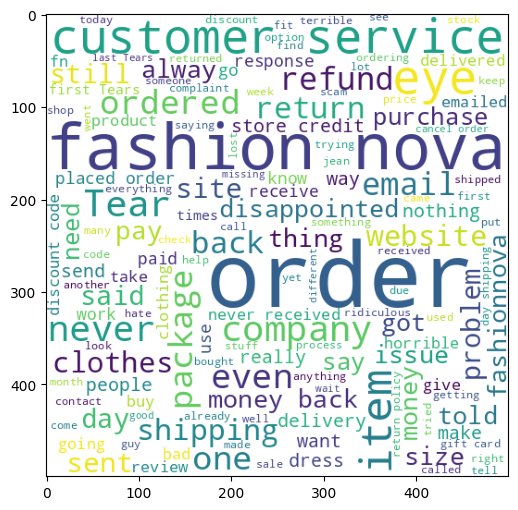

In [ ]:
negative_wc = wc.generate(df[df['vader_sentiment'] == 'negative']['clean_review_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(negative_wc)

**PALAVRAS QUE MAIS APARECEM COMO NEUTRAS NAS AVALIAÇÕES**

In [ ]:
neutral_data = []
for text in df[df['vader_sentiment'] == 'neutral']['clean_review_text'].tolist():
    for t in text.split():
        negative_data.append(t)

In [ ]:
## Exibindo as 10 palavras negativas mais frequentes nos títulos das avaliações

neutral_data_df = pd.DataFrame(neutral_data, columns=['Word'])

word_counts = neutral_data_df['Word'].value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']
print(word_counts.head(10))

       Word  Frequency
0   service        617
1  customer        611
2     order        559
3   fashion        458
4      nova        413
5  horrible        314
6     never        310
7      eyes        287
8     Tears        286
9        in        286


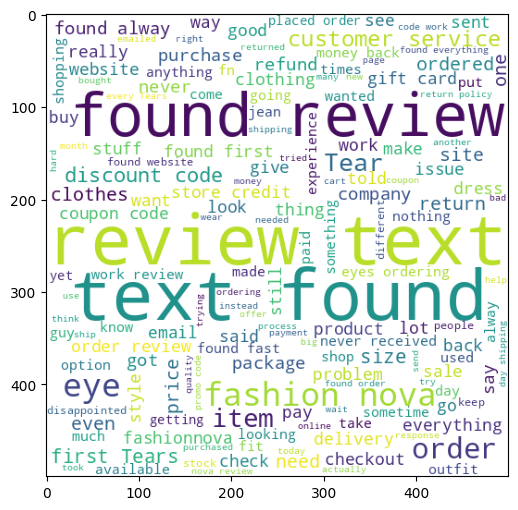

In [ ]:
neutral_wc = wc.generate(df[df['vader_sentiment'] == 'neutral']['clean_review_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(negative_wc)

# **Analisando os Títulos das Avaliações**

**IMPRESSÕES POSITIVAS PRESENTES NOS TÍTULOS**

In [ ]:
positive_data = []
for text in df[df['vader_sentiment'] == 'positive']['clean_review_title'].tolist():
    for t in text.split():
        positive_data.append(t)

In [ ]:
## Exibindo as 10 palavras positivas mais frequentes nos títulos das avaliações

positive_data_df = pd.DataFrame(positive_data, columns=['Word'])

word_counts = positive_data_df['Word'].value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']
print(word_counts.head(10))

       Word  Frequency
0      love      15257
1     great      10585
2   fashion       7385
3      nova       6449
4      easy       5266
5      good       5012
6   clothes       4266
7    always       2808
8  shopping       2421
9   quality       2361


<ipython-input-381-e3c0a33f61c5>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




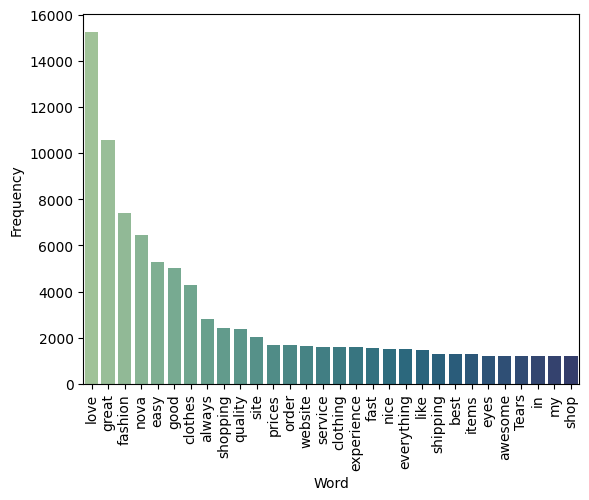

In [ ]:
most_common_words = Counter(positive_data).most_common(30)
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

sns.barplot(x='Word', y='Frequency', data=common_words_df, palette='crest')
plt.xticks(rotation='vertical')
plt.show()

**IMPRESSÕES NEGATIVAS PRESENTES NOS TÍTULOS**

In [ ]:
negative_data = []
for text in df[df['vader_sentiment'] == 'negative']['clean_review_title'].tolist():
    for t in text.split():
        negative_data.append(t)

In [ ]:
## Exibindo as 10 palavras negativas mais frequentes nos títulos das avaliações

negative_data_df = pd.DataFrame(negative_data, columns=['Word'])

word_counts = negative_data_df['Word'].value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']
print(word_counts.head(10))

       Word  Frequency
0   service        617
1  customer        611
2     order        559
3   fashion        458
4      nova        413
5  horrible        314
6     never        310
7      eyes        287
8     Tears        286
9        in        286


<ipython-input-387-f8f3fcc169ab>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




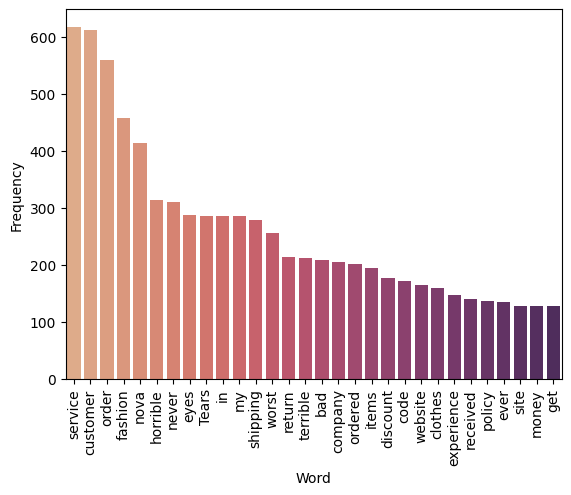

In [ ]:
most_common_words = Counter(negative_data).most_common(30)
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

sns.barplot(x='Word', y='Frequency', data=common_words_df, palette=sns.color_palette("flare", len(common_words_df)))
plt.xticks(rotation='vertical')
plt.show()

**IMPRESSÕES NEUTRAS PRESENTES NOS TÍTULOS**

In [ ]:
neutral_data = []
for text in df[df['vader_sentiment'] == 'negative']['clean_review_title'].tolist():
    for t in text.split():
        neutral_data.append(t)

In [ ]:
## Exibindo as 10 palavras neutras mais frequentes nos títulos das avaliações

neutral_data_df = pd.DataFrame(negative_data, columns=['Word'])

word_counts = neutral_data_df['Word'].value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']
print(word_counts.head(10))

      Word  Frequency
0   review      38286
1    found      38206
2     text      38135
3    order       7180
4     eyes       4671
5       my       4659
6    Tears       4659
7       in       4659
8  fashion       4155
9     nova       3905


<ipython-input-400-7d6081609fae>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




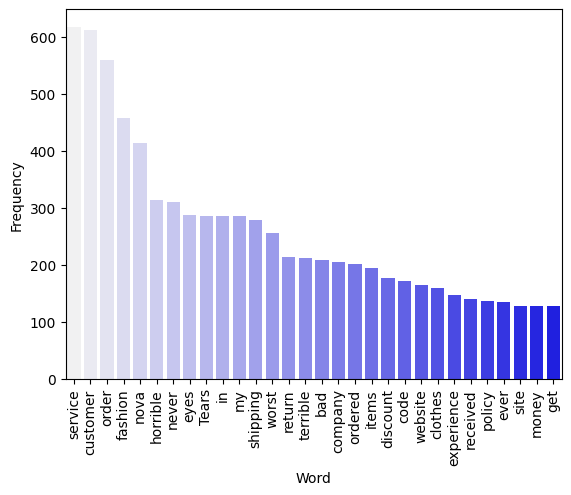

In [ ]:
most_common_words = Counter(neutral_data).most_common(30)
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

sns.barplot(x='Word', y='Frequency', data=common_words_df, palette=sns.color_palette("light:b", len(common_words_df)))
plt.xticks(rotation='vertical')
plt.show()